# Jumba Demo 001

## Sum of first X integers

As a test function we define a function that given X calulates the sum of the range `[0, X)`.

We define `fun_pure(X)` to test the function in pure Python.

Then we define `fun_jit(x)` that is identical but just with decorator `@jit` in the definition.

In [1]:
from numba import jit

def fun_pure(x):
    y = 0
    num = int(x) # NOTE: this cast allows us to pass any type for x
    for x_ in range(num):  
        y += x_
    return y

@jit
def fun_jit(x):
    y = 0
    num = int(x) # NOTE: this cast allows us to use any type for x
    for x_ in range(num):  
        y += x_
    return y


Lets define a benchmark for them:

In [2]:
from IPython.display import display
from itertools import combinations
import time
import pandas as pd
import matplotlib
%matplotlib inline

def run_benchmarks(num_runs, funs, *pars):
    def _run_sequence(fun):
        for i in range(num_runs):
            start = time.time()
            fun(*pars)
            yield 1000. * (time.time() - start) # Yields elapsed in ms
    df = pd.DataFrame()
    for fun in funs:
        df[fun.__name__] = pd.Series(_run_sequence(fun),
                                     name=fun.__name__)
    df.plot(figsize=(10,5), title='Run times (ms)')
    
    print('Performance ratios')
    comb = combinations(((fun.__name__,
                          df[fun.__name__].values[0],
                          df[fun.__name__].tail(-1).mean())
                         for fun in funs), 2)
    for (nameA, headA, meanA), (nameB, headB, meanB) in comb:
        print('- {}[0]/{}[0] = {:,}'.format(nameA, nameB, headA / headB))
        print('- {}[1:]/{}[1:] = {:,}'.format(nameA, nameB, meanA / meanB))

And lets execute the two flawours of our functions one after the other:

Performance ratios
- fun_pure[0]/fun_jit[0] = 2.0603205550623844
- fun_pure[1:]/fun_jit[1:] = 225,710.4968152866


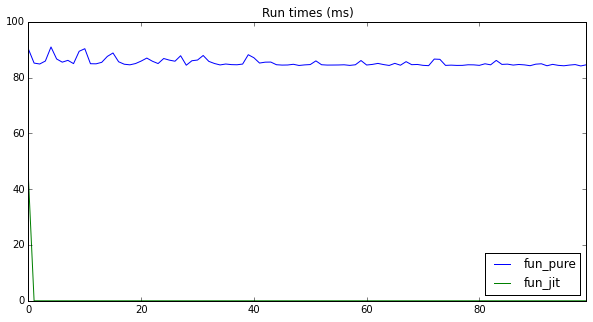

In [3]:
run_benchmarks(100, [fun_pure, fun_jit], 1000000)

A second run to prove JIT caching mechanism

Performance ratios
- fun_pure[0]/fun_jit[0] = 30,915.166666666668
- fun_pure[1:]/fun_jit[1:] = 228,765.5496688742


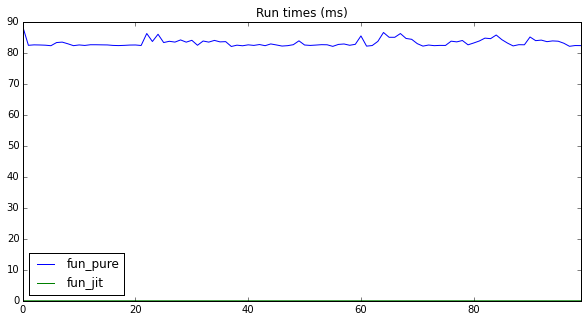

In [4]:
run_benchmarks(100, [fun_pure, fun_jit], 1000000)

Looks like Numba JIT functionality works in the following way:
- During parsing generates a native generic `fun(x: ?)`
- For each first run of `fun(x: X)` where `X` is the type of `x` it generate a specialized `fun(x: X)` while running the good old `fun(x: ?)`.
- Next times uses the super-fast variant `fun(x: X)`

## Lets try with another input types: float, str

Our function execution does not change if we change the type of X because we always cast it to `int`.

The fact is that `numba` does known and follow the same generation on demand for any type we use for `X`.

In fact:

Performance ratios
- fun_pure[0]/fun_jit[0] = 2.4920480425461533
- fun_pure[1:]/fun_jit[1:] = 221,372.23602484472


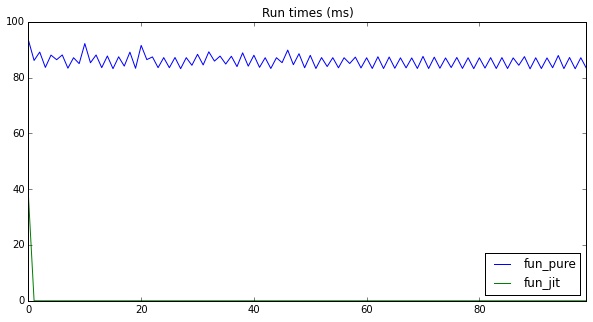

In [5]:
run_benchmarks(100, [fun_pure, fun_jit], 1000000.)

Performance ratios
- fun_pure[0]/fun_jit[0] = 0.9401110715369293
- fun_pure[1:]/fun_jit[1:] = 17,796.010593220337


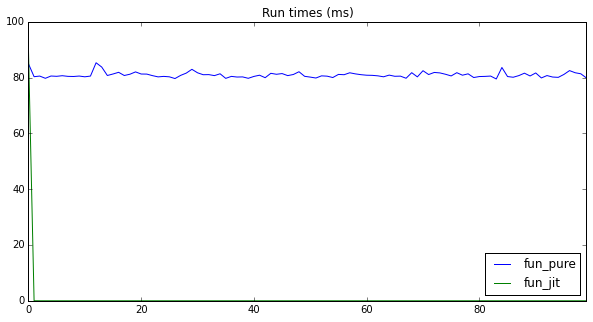

In [6]:
run_benchmarks(100, [fun_pure, fun_jit], '1000000')

The same behaviour as with integers, it generates a new specialization of the function at each first run with a given type.

Other notable features of Numba:
- it also supports **NVIDIA CUDA**, the same functions can be execute by the CPU (Pure Python or Jitted), or by the GPU.
- it supports the already fast numerical library **Numpy** allowing to be fast also with functions that cannot be efficiently obtained with stock functions.
- it supports parallelism out of the box, also allows to disable during its execution the infamous `GIL`.

##And what about adding Cython to the game?

In [7]:
%load_ext Cython

In [8]:
%%cython
def fun_c(x):
    cdef int y = 0
    cdef int x_ = 0
    cdef int num = int(x) # NOTE: this cast allows us to use any type for x
    for x_ in range(num):  
        y += x_
    return y

/Users/Riccardo/anaconda/lib/python3.4/site-packages/IPython/utils/path.py:264: UserWarning: get_ipython_cache_dir has moved to the IPython.paths module
  warn("get_ipython_cache_dir has moved to the IPython.paths module")


Performance ratios
- fun_pure[0]/fun_jit[0] = 28,854.846153846152
- fun_pure[1:]/fun_jit[1:] = 214,536.15757575756
- fun_pure[0]/fun_c[0] = 75,022.6
- fun_pure[1:]/fun_c[1:] = 333,947.7924528302
- fun_jit[0]/fun_c[0] = 2.6
- fun_jit[1:]/fun_c[1:] = 1.5566037735849059


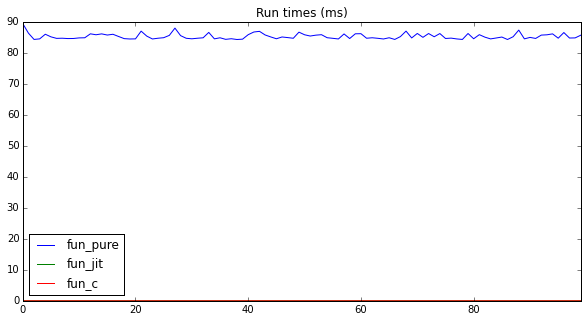

In [9]:
run_benchmarks(100, [fun_pure, fun_jit, fun_c], 1000000)

**Cython** is still the kind of the hill here!

At least for this simple use-case where we iterate through a range of integers.

This is the generated C code by Cython for the internal loop:

```C
for (__pyx_v_x_ = 0; __pyx_v_x_ < __pyx_t_2; __pyx_v_x_+=1)
{
     __pyx_v_y = (__pyx_v_y + __pyx_v_x_);
}
```

It really cannot go faster than it, and JUMBA is respectably just twice slower...